In [10]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

__all__ = [
    'bfs_edges', 'bfs_tree', 'bfs_predecessors', 'bfs_successors',
    'descendants_at_distance'
]


def generic_bfs_edges(G, source, neighbors=None, depth_limit=None):
    """Iterate over edges in a breadth-first search.

    The breadth-first search begins at `source` and enqueues the
    neighbors of newly visited nodes specified by the `neighbors`
    function.

    Parameters
    ----------
    G : NetworkX graph

    source : node
        Starting node for the breadth-first search; this function
        iterates over only those edges in the component reachable from
        this node.

    neighbors : function
        A function that takes a newly visited node of the graph as input
        and returns an *iterator* (not just a list) of nodes that are
        neighbors of that node. If not specified, this is just the
        ``G.neighbors`` method, but in general it can be any function
        that returns an iterator over some or all of the neighbors of a
        given node, in any order.

    depth_limit : int, optional(default=len(G))
        Specify the maximum search depth

    Yields
    ------
    edge
        Edges in the breadth-first search starting from `source`.

    Examples
    --------
    >>> G = nx.path_graph(3)
    >>> print(list(nx.bfs_edges(G,0)))
    [(0, 1), (1, 2)]
    >>> print(list(nx.bfs_edges(G, source=0, depth_limit=1)))
    [(0, 1)]

    Notes
    -----
    This implementation is from `PADS`_, which was in the public domain
    when it was first accessed in July, 2004.  The modifications
    to allow depth limits are based on the Wikipedia article
    "`Depth-limited-search`_".

    .. _PADS: http://www.ics.uci.edu/~eppstein/PADS/BFS.py
    .. _Depth-limited-search: https://en.wikipedia.org/wiki/Depth-limited_search
    """
    visited = {source}
    if depth_limit is None:
        depth_limit = len(G)
    queue = deque([(source, depth_limit, neighbors(source))])
    while queue:
        parent, depth_now, children = queue[0]
        try:
            child = next(children)
            if child not in visited:
                yield parent, child
                visited.add(child)
                if depth_now > 1:
                    queue.append((child, depth_now - 1, neighbors(child)))
        except StopIteration:
            queue.popleft()


def bfs_edges(G, source, reverse=False, depth_limit=None):
    """Iterate over edges in a breadth-first-search starting at source.

    Parameters
    ----------
    G : NetworkX graph

    source : node
       Specify starting node for breadth-first search; this function
       iterates over only those edges in the component reachable from
       this node.

    reverse : bool, optional
       If True traverse a directed graph in the reverse direction

    depth_limit : int, optional(default=len(G))
        Specify the maximum search depth

    Returns
    -------
    edges: generator
       A generator of edges in the breadth-first-search.

    Examples
    --------
    To get the edges in a breadth-first search::

        >>> G = nx.path_graph(3)
        >>> list(nx.bfs_edges(G, 0))
        [(0, 1), (1, 2)]
        >>> list(nx.bfs_edges(G, source=0, depth_limit=1))
        [(0, 1)]

    To get the nodes in a breadth-first search order::

        >>> G = nx.path_graph(3)
        >>> root = 2
        >>> edges = nx.bfs_edges(G, root)
        >>> nodes = [root] + [v for u, v in edges]
        >>> nodes
        [2, 1, 0]

    Notes
    -----
    The naming of this function is very similar to bfs_edges. The difference
    is that 'edge_bfs' yields edges even if they extend back to an already
    explored node while 'bfs_edges' yields the edges of the tree that results
    from a breadth-first-search (BFS) so no edges are reported if they extend
    to already explored nodes. That means 'edge_bfs' reports all edges while
    'bfs_edges' only report those traversed by a node-based BFS. Yet another
    description is that 'bfs_edges' reports the edges traversed during BFS
    while 'edge_bfs' reports all edges in the order they are explored.

    Based on http://www.ics.uci.edu/~eppstein/PADS/BFS.py.
    by D. Eppstein, July 2004. The modifications
    to allow depth limits based on the Wikipedia article
    "`Depth-limited-search`_".

    .. _Depth-limited-search: https://en.wikipedia.org/wiki/Depth-limited_search

    See Also
    --------
    bfs_tree
    dfs_edges
    edge_bfs

    """
    if reverse and G.is_directed():
        successors = G.predecessors
    else:
        successors = G.neighbors
    # TODO In Python 3.3+, this should be `yield from ...`
    for e in generic_bfs_edges(G, source, successors, depth_limit):
        yield e



def bfs_tree(G, source, reverse=False, depth_limit=None):
    """Returns an oriented tree constructed from of a breadth-first-search
    starting at source.

    Parameters
    ----------
    G : NetworkX graph

    source : node
       Specify starting node for breadth-first search

    reverse : bool, optional
       If True traverse a directed graph in the reverse direction

    depth_limit : int, optional(default=len(G))
        Specify the maximum search depth

    Returns
    -------
    T: NetworkX DiGraph
       An oriented tree

    Examples
    --------
    >>> G = nx.path_graph(3)
    >>> print(list(nx.bfs_tree(G,1).edges()))
    [(1, 0), (1, 2)]
    >>> H = nx.Graph()
    >>> nx.add_path(H, [0, 1, 2, 3, 4, 5, 6])
    >>> nx.add_path(H, [2, 7, 8, 9, 10])
    >>> print(sorted(list(nx.bfs_tree(H, source=3, depth_limit=3).edges())))
    [(1, 0), (2, 1), (2, 7), (3, 2), (3, 4), (4, 5), (5, 6), (7, 8)]


    Notes
    -----
    Based on http://www.ics.uci.edu/~eppstein/PADS/BFS.py
    by D. Eppstein, July 2004. The modifications
    to allow depth limits based on the Wikipedia article
    "`Depth-limited-search`_".

    .. _Depth-limited-search: https://en.wikipedia.org/wiki/Depth-limited_search

    See Also
    --------
    dfs_tree
    bfs_edges
    edge_bfs
    """
    T = nx.DiGraph()
    T.add_node(source)
    edges_gen = bfs_edges(G, source, reverse=reverse, depth_limit=depth_limit)
    T.add_edges_from(edges_gen)
    return T



def bfs_predecessors(G, source, depth_limit=None):
    """Returns an iterator of predecessors in breadth-first-search from source.

    Parameters
    ----------
    G : NetworkX graph

    source : node
       Specify starting node for breadth-first search

    depth_limit : int, optional(default=len(G))
        Specify the maximum search depth

    Returns
    -------
    pred: iterator
        (node, predecessors) iterator where predecessors is the list of
        predecessors of the node.

    Examples
    --------
    >>> G = nx.path_graph(3)
    >>> print(dict(nx.bfs_predecessors(G, 0)))
    {1: 0, 2: 1}
    >>> H = nx.Graph()
    >>> H.add_edges_from([(0, 1), (0, 2), (1, 3), (1, 4), (2, 5), (2, 6)])
    >>> print(dict(nx.bfs_predecessors(H, 0)))
    {1: 0, 2: 0, 3: 1, 4: 1, 5: 2, 6: 2}
    >>> M = nx.Graph()
    >>> nx.add_path(M, [0, 1, 2, 3, 4, 5, 6])
    >>> nx.add_path(M, [2, 7, 8, 9, 10])
    >>> print(sorted(nx.bfs_predecessors(M, source=1, depth_limit=3)))
    [(0, 1), (2, 1), (3, 2), (4, 3), (7, 2), (8, 7)]


    Notes
    -----
    Based on http://www.ics.uci.edu/~eppstein/PADS/BFS.py
    by D. Eppstein, July 2004. The modifications
    to allow depth limits based on the Wikipedia article
    "`Depth-limited-search`_".

    .. _Depth-limited-search: https://en.wikipedia.org/wiki/Depth-limited_search

    See Also
    --------
    bfs_tree
    bfs_edges
    edge_bfs
    """
    for s, t in bfs_edges(G, source, depth_limit=depth_limit):
        yield (t, s)



def bfs_successors(G, source, depth_limit=None):
    """Returns an iterator of successors in breadth-first-search from source.

    Parameters
    ----------
    G : NetworkX graph

    source : node
       Specify starting node for breadth-first search

    depth_limit : int, optional(default=len(G))
        Specify the maximum search depth

    Returns
    -------
    succ: iterator
       (node, successors) iterator where successors is the list of
       successors of the node.

    Examples
    --------
    >>> G = nx.path_graph(3)
    >>> print(dict(nx.bfs_successors(G,0)))
    {0: [1], 1: [2]}
    >>> H = nx.Graph()
    >>> H.add_edges_from([(0, 1), (0, 2), (1, 3), (1, 4), (2, 5), (2, 6)])
    >>> print(dict(nx.bfs_successors(H, 0)))
    {0: [1, 2], 1: [3, 4], 2: [5, 6]}
    >>> G = nx.Graph()
    >>> nx.add_path(G, [0, 1, 2, 3, 4, 5, 6])
    >>> nx.add_path(G, [2, 7, 8, 9, 10])
    >>> print(dict(nx.bfs_successors(G, source=1, depth_limit=3)))
    {1: [0, 2], 2: [3, 7], 3: [4], 7: [8]}


    Notes
    -----
    Based on http://www.ics.uci.edu/~eppstein/PADS/BFS.py
    by D. Eppstein, July 2004.The modifications
    to allow depth limits based on the Wikipedia article
    "`Depth-limited-search`_".

    .. _Depth-limited-search: https://en.wikipedia.org/wiki/Depth-limited_search

    See Also
    --------
    bfs_tree
    bfs_edges
    edge_bfs
    """
    parent = source
    children = []
    for p, c in bfs_edges(G, source, depth_limit=depth_limit):
        if p == parent:
            children.append(c)
            continue
        yield (parent, children)
        children = [c]
        parent = p
    yield (parent, children)



def descendants_at_distance(G, source, distance):
    """Returns all nodes at a fixed `distance` from `source` in `G`.

    Parameters
    ----------
    G : NetworkX DiGraph
        A directed graph
    source : node in `G`
    distance : the distance of the wanted nodes from `source`

    Returns
    -------
    set()
        The descendants of `source` in `G` at the given `distance` from `source`
    """
    if not G.has_node(source):
        raise nx.NetworkXError("The node %s is not in the graph." % source)
    current_distance = 0
    queue = {source}
    visited = {source}

    # this is basically BFS, except that the queue only stores the nodes at
    # current_distance from source at each iteration
    while queue:
        if current_distance == distance:
            return queue

        current_distance += 1

        next_vertices = set()
        for vertex in queue:
            for child in G[vertex]:
                if child not in visited:
                    visited.add(child)
                    next_vertices.add(child)

        queue = next_vertices

    return set()

In [19]:
G = nx.path_graph(3)
A = nx.bfs_tree(G,1)
# print(A)
# [(1, 0), (1, 2)]

In [26]:
H = nx.Graph()
nx.add_path(H, ["0", "1", "2", "3", "4", "5", "6"])
nx.add_path(H, ["2", "7", "8", "9", "10"])
B = nx.bfs_tree(H, source="3", depth_limit=3)
# print(sorted(list(nx.bfs_tree(H, source=3, depth_limit=3).edges())))
# [(1, 0), (2, 1), (2, 7), (3, 2), (3, 4), (4, 5), (5, 6), (7, 8)]

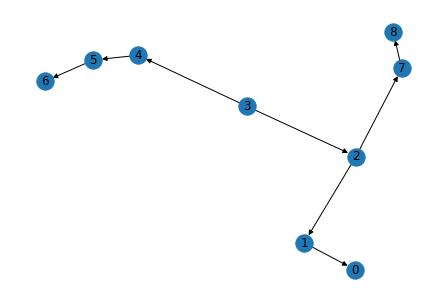

In [28]:
nx.draw(B, with_labels = True)
plt.show()